In [1]:
library(Signac)
library(Seurat)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(patchwork)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.i

In [2]:
counts <- Read10X("/mnt/disk1/xiaojk/data/mousebrain/GSE126074_AdBrainCortex_SNAREseq_atac/", gene.column = 1)

In [3]:
max(counts)

[1] 16

In [4]:
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  fragments = '/mnt/disk1/xiaojk/data/mousebrain/fragments.sort.bed.gz',
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks"
)

Computing hash

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [5]:
chrom_assay

ChromatinAssay data with 204268 features for 10309 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

In [6]:
pbmc[['peaks']]

ChromatinAssay data with 204268 features for 10309 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

In [7]:
granges(pbmc)

GRanges object with 204268 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3094772-3095489      *
       [2]     chr1   3119556-3120739      *
       [3]     chr1   3121334-3121696      *
       [4]     chr1   3164929-3165186      *
       [5]     chr1   3167174-3167517      *
       ...      ...               ...    ...
  [204264]     chrY 90732105-90732474      *
  [204265]     chrY 90740917-90741416      *
  [204266]     chrY 90741519-90742734      *
  [204267]     chrY 90742824-90743114      *
  [204268]     chrY 90744284-90744731      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

In [8]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)

# change to UCSC style since the data was mapped to hg19
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "mm10"

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [9]:
# add the gene information to the object
Annotation(pbmc) <- annotations

In [10]:
Annotation(pbmc)

GRanges object with 1763965 ranges and 5 metadata columns:
                     seqnames          ranges strand |              tx_id
                        <Rle>       <IRanges>  <Rle> |        <character>
  ENSMUSE00001236884     chr3 3508030-3508332      + | ENSMUST00000108393
  ENSMUSE00000676606     chr3 3634150-3634347      + | ENSMUST00000108394
  ENSMUSE00001345708     chr3 3638059-3638230      + | ENSMUST00000108393
  ENSMUSE00001345708     chr3 3638059-3638230      + | ENSMUST00000108394
  ENSMUSE00000149313     chr3 3641223-3641317      + | ENSMUST00000108393
                 ...      ...             ...    ... .                ...
  ENSMUST00000082414    chrMT     10167-11544      + | ENSMUST00000082414
  ENSMUST00000082418    chrMT     11742-13565      + | ENSMUST00000082418
  ENSMUST00000082419    chrMT     13552-14070      - | ENSMUST00000082419
  ENSMUST00000082421    chrMT     14145-15288      + | ENSMUST00000082421
  ENSMUST00000084013    chrMT      9877-10173      + 

In [17]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc, fast = FALSE)

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



In [19]:
pbmc$blacklist_fraction <- FractionCountsInRegion(
  object = pbmc,
  assay = 'peaks',
  regions = blacklist_mm10
)

In [21]:
# add blacklist ratio and fraction of reads in peaks
# pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
# pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

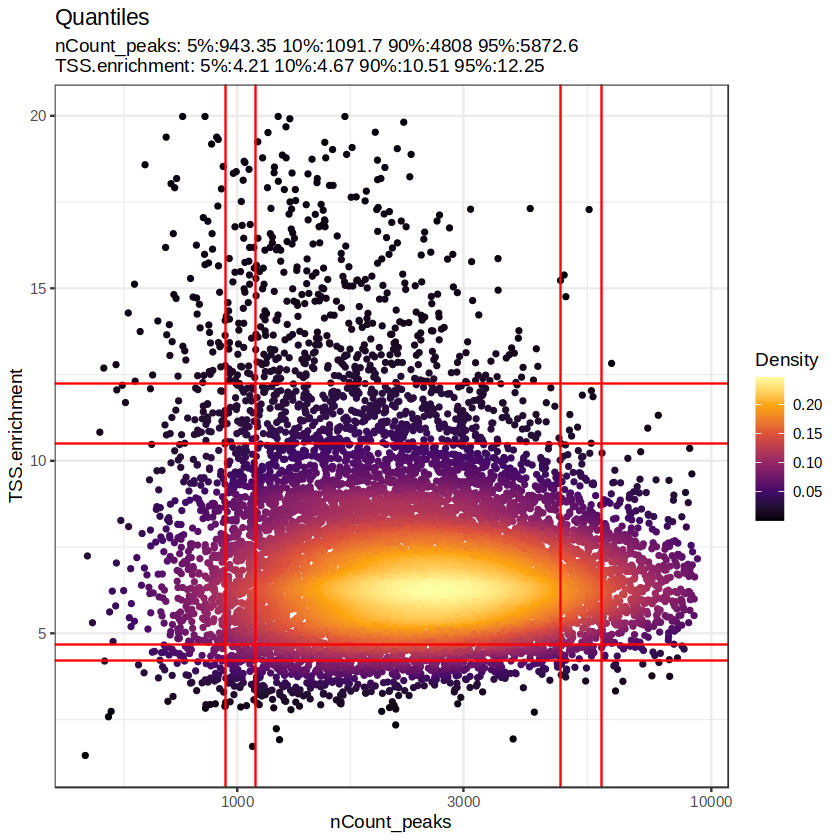

In [23]:
DensityScatter(pbmc, x = 'nCount_peaks', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

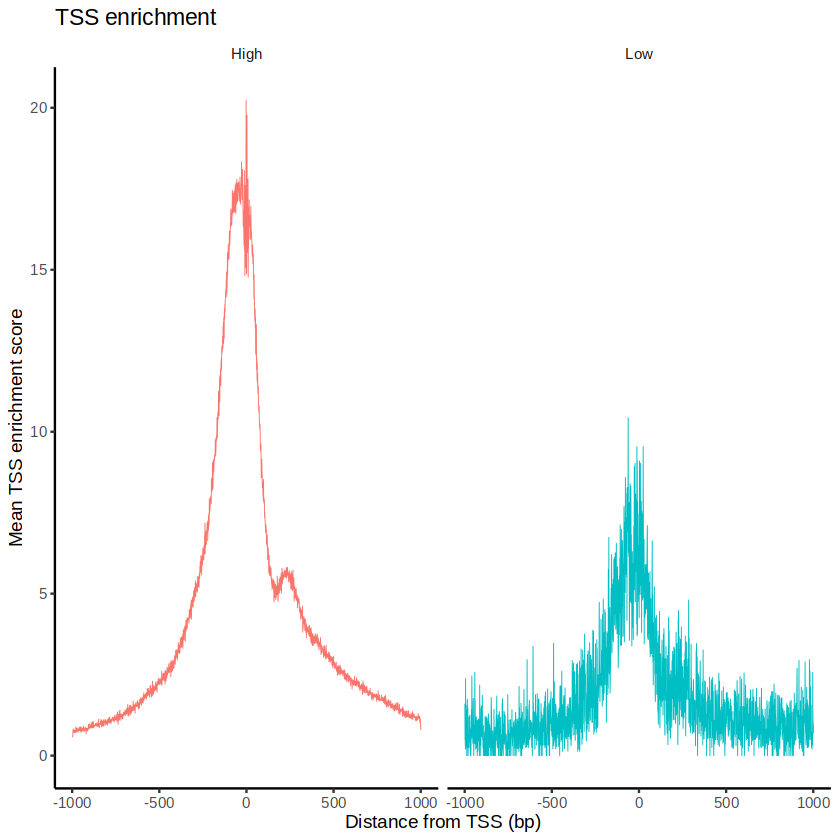

In [25]:
pbmc$high.tss <- ifelse(pbmc$TSS.enrichment > 3, 'High', 'Low')
TSSPlot(pbmc, group.by = 'high.tss') + NoLegend()

In [27]:
# pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
# FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')

Warning message in FetchData.Seurat(object = object, vars = features, slot = slot):
"The following requested variables were not found: pct_reads_in_peaks"


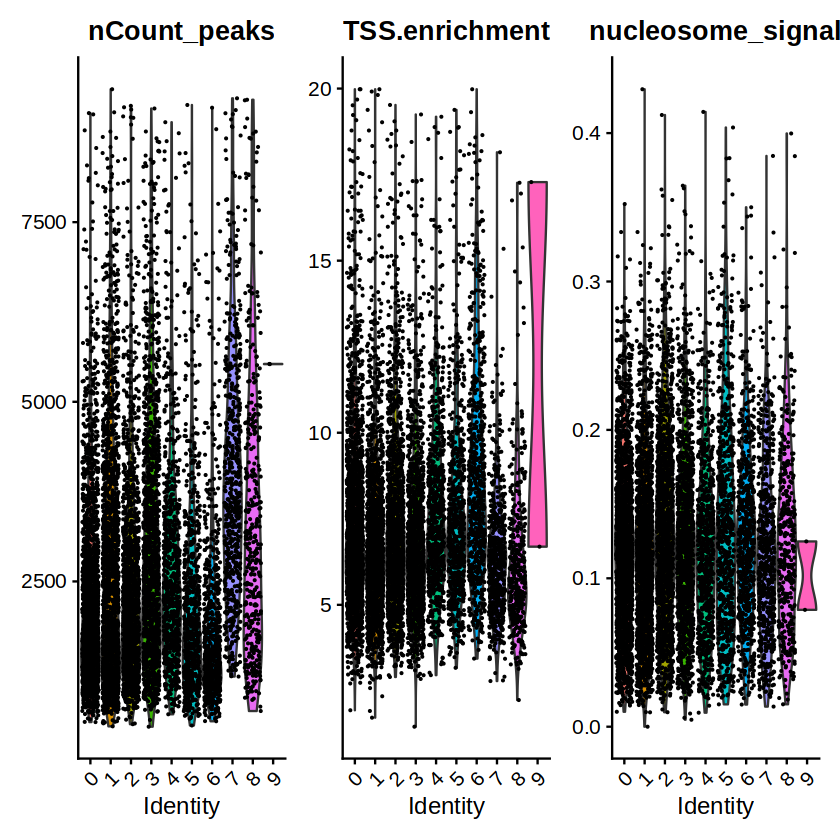

In [29]:
VlnPlot(
  object = pbmc,
  features = c('nCount_peaks', 'TSS.enrichment', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 3
)

In [31]:
pbmc <- subset(
  x = pbmc,
  subset = blacklist_fraction < 0.03 &
    TSS.enrichment < 20 
)
pbmc

An object of class Seurat 
204268 features across 10028 samples within 1 assay 
Active assay: peaks (204268 features, 204268 variable features)
 2 dimensional reductions calculated: lsi, umap

In [33]:
pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0')
pbmc <- RunSVD(pbmc)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



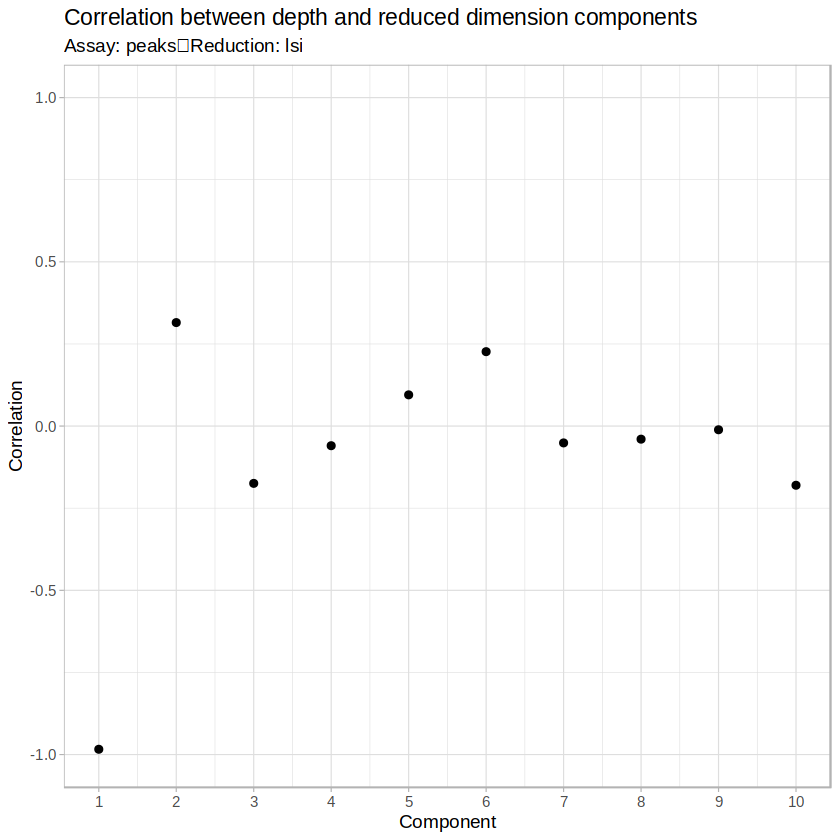

In [35]:
DepthCor(pbmc)

In [37]:
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindClusters(object = pbmc, verbose = FALSE, algorithm = 3)
DimPlot(object = pbmc, label = TRUE) + NoLegend()

22:54:55 UMAP embedding parameters a = 0.9922 b = 1.112

22:54:55 Read 10028 rows and found 29 numeric columns

22:54:55 Using Annoy for neighbor search, n_neighbors = 30

22:54:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:54:56 Writing NN index file to temp file /tmp/Rtmpvh96SR/file3a4e7657af2f5

22:54:56 Searching Annoy index using 1 thread, search_k = 3000

22:54:58 Annoy recall = 100%

22:55:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:55:03 Initializing from normalized Laplacian + noise (using irlba)

22:55:04 Commencing optimization for 200 epochs, with 438052 positive edges

22:55:10 Optimization finished

Computing nearest neighbor graph

Computing SNN



ERROR: Error in FindClusters.Seurat(object = pbmc, verbose = FALSE, algorithm = 3): Provided graph.name not present in Seurat object


In [ ]:
gene.activities <- GeneActivity(pbmc)

In [ ]:
str(gene.activities)

In [ ]:
pbmc[['RNA']] <- CreateAssayObject(counts = gene.activities)
pbmc <- NormalizeData(
  object = pbmc,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(pbmc$nCount_RNA)
)

In [ ]:
DefaultAssay(pbmc) <- 'RNA'

In [ ]:
rna <- pbmc[['RNA']]

In [ ]:
seurat_obj <- CreateSeuratObject(counts = pbmc[['RNA']])

In [ ]:
seurat_obj[["RNA"]] <- pbmc[['RNA']]

In [ ]:
seurat_obj